# calcPCs

This is the fourth step in reproducing the cluster analysis following [Amini and Straus 2019]
(https://doi.org/10.1007/s00382-018-4409-7)

This program calculates the EOFs and PCs.  PCs are written to an output file.
* Input File: `/glade/work/mkorendy/metisregimes/era5.z500_pna_NDJFM_lpfilter_twicedaily_10days.1980-2019.anoms.nc`
* Input File: `/glade/work/mkorendy/metisregimes/era5.u250_pna_NDJFM_lpfilter_twicedaily_10days.1980-2019.anoms.nc`
* Output File: `/glade/work/mkorendy/metisregimes/era5.z500_u250_pna_NDJFM_lpfilter_twicedaily_10days.1980-2019.pcs.nc`
* Output File: `/glade/work/mkorendy/metisregimes/era5.z500_u250_pna_NDJFM_lpfilter_twicedaily_10days.1980-2019.eofs.nc`

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

from eofs.multivariate.standard import MultivariateEof
from eofs.xarray import Eof

### Define Input and Output Data

In [2]:
# Input
path='/glade/work/mkorendy/metisregimes/'
f_z= path + 'era5.z500_pna_NDJFM_lpfilter_twicedaily_10days.1986-2015.anoms.nc'
f_u = path + 'era5.u250_pna_NDJFM_lpfilter_twicedaily_10days.1986-2015.anoms.nc'

# Output
outfile= path + 'era5.z500_u250_pna_NDJFM_lpfilter_twicedaily_10days.1986-2015.pcs.nc'
eofoutfile= path + 'era5.z500_u250_pna_NDJFM_lpfilter_twicedaily_10days.1986-2015.eofs.nc'

### Define constants

In [3]:
npcs=12 #number of pcs

### Read Data

In [4]:
print(path+f_z)
ds_z=xr.open_dataset(f_z,decode_times=False)
ds_u = xr.open_dataset(f_u, decode_times = False)

/glade/work/mkorendy/metisregimes//glade/work/mkorendy/metisregimes/era5.z500_pna_NDJFM_lpfilter_twicedaily_10days.1986-2015.anoms.nc


### Convert Z500 from m^2/s^2 to m

In [5]:
ds_z['z500']=ds_z['z500']/9.81
ds_z

<xarray.Dataset>
Dimensions:  (lat: 22, lon: 53, time: 8160)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 8153 8154 8155 8156 8157 8158 8159
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500     (time, lat, lon) float64 121.3 135.1 149.6 ... 71.32 75.12 75.92

### Quick test plot

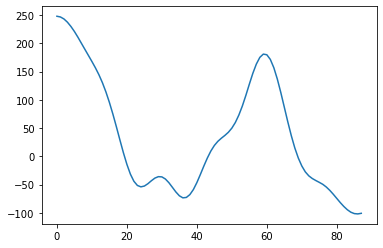

In [6]:
plt.plot(ds_z['z500'][0:88,12,25])

In [7]:
ds = xr.merge([ds_z,ds_u])
ds

<xarray.Dataset>
Dimensions:  (lat: 22, lon: 53, time: 8160)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 8153 8154 8155 8156 8157 8158 8159
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500     (time, lat, lon) float64 121.3 135.1 149.6 ... 71.32 75.12 75.92
    u250     (time, lat, lon) float64 ...

### Calculate Latitude Weights

In [8]:
coslat = np.cos(np.deg2rad(ds['lat'].values))
weights_array = np.sqrt(coslat)[:, np.newaxis]

### Apply Latitude Weighting

In [9]:
ds['z500']=ds['z500']*weights_array
ds['u250']=ds['u250']*weights_array

### Normalize the Data

In [10]:
norm_z500=np.sqrt((ds['z500'].var(dim='time')).mean(dim=['lat','lon']))
norm_u250=np.sqrt(ds['u250'].var(dim='time').mean(dim=['lat','lon']))

ds['z500']=ds['z500']/norm_z500
ds['u250']=ds['u250']/norm_u250

### Check values of normalization (this the variance, normalized by std)

In [11]:
print(norm_z500.values*norm_z500.values)
print(norm_u250.values*norm_u250.values)

5225.387881847432
82.12230029658227


### Create the eof solver with latitude weighted data

In [12]:
solver=MultivariateEof([ds['z500'].values,ds['u250'].values])

### Get the EOF (spatial pattern)

In [13]:
eof1_list=solver.eofs(neofs=npcs,eofscaling=0) #first eof?

In [14]:
eof1_array = np.array(eof1_list)
eof1_array = eof1_array/weights_array

In [15]:
#PUT EOFs in a dataset
print(eof1_array.shape)
eof1_z_ds = xr.DataArray(eof1_array[0], coords={'eofnum':np.arange(npcs),'lat':ds['z500']['lat'].values,
                                                'lon':ds['z500']['lon'].values}, dims=['eofnum','lat','lon'])
eof1_z_ds = eof1_z_ds.to_dataset(name='z500_eofs')
eof1_u_ds = xr.DataArray(eof1_array[1], coords={'eofnum':np.arange(npcs),'lat':ds['z500']['lat'].values,
                                                'lon':ds['z500']['lon'].values}, dims=['eofnum','lat','lon'])
eof1_u_ds = eof1_u_ds.to_dataset(name='u250_eofs')
eof1_ds = xr.merge([eof1_z_ds,eof1_u_ds])
print(eof1_ds)

(2, 12, 22, 53)
<xarray.Dataset>
Dimensions:    (eofnum: 12, lat: 22, lon: 53)
Coordinates:
  * eofnum     (eofnum) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * lat        (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon        (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    z500_eofs  (eofnum, lat, lon) float64 -0.004655 -0.004946 ... -0.004472
    u250_eofs  (eofnum, lat, lon) float64 -0.002908 -0.003079 ... 0.02022


### Plot the EOFs

In [16]:
# Map settings
cm = 180
proj = ccrs.PlateCarree(central_longitude=cm)
minlon = -30 + cm
maxlon = +120 + cm
lat_labels=np.arange(20,80,20)
lon_labels=np.arange(150,330,30)
extent=[minlon,maxlon,20,80]

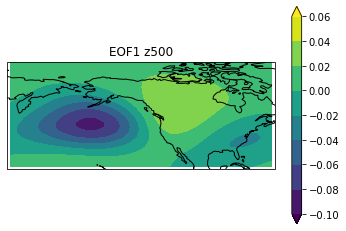

In [17]:
# EOF 1 Z500
levs=np.arange(-0.1,0.07,0.02)
z500_eof1=eof1_list[0][0,:,:]/weights_array
ax=plt.axes(projection=proj)
ax.set_extent(extent,crs=ccrs.PlateCarree())
cs=ax.contourf(ds['lon'],ds['lat'],
               z500_eof1*-1, levs,
               transform=ccrs.PlateCarree(),
              extend='both')
ax.set_title('EOF1 z500')
ax.coastlines()
plt.colorbar(cs)

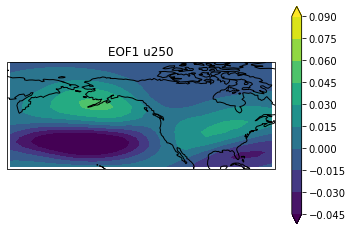

In [18]:
# EOF 1 U250
levs=np.arange(-0.045,0.1,0.015)
u250_eof1=eof1_list[1][0,:,:]/weights_array
ax=plt.axes(projection=proj)
ax.set_extent(extent,crs=ccrs.PlateCarree())
cs=ax.contourf(ds['lon'],ds['lat'],
               u250_eof1,levs,
               transform=ccrs.PlateCarree(),
               extend='both')
ax.set_title('EOF1 u250')
ax.coastlines()
plt.colorbar(cs)

0.09393827455210649 -0.07951482250742128


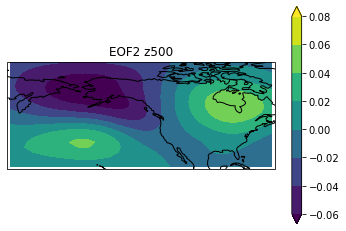

In [19]:
# EOF 2 Z500
levs=np.arange(-0.06,0.08,0.02)
z500_eof2=eof1_list[0][1,:,:]/weights_array
ax=plt.axes(projection=proj)
ax.set_extent(extent,crs=ccrs.PlateCarree())
cs=ax.contourf(ds['lon'],ds['lat'],
               z500_eof2*-1, levs,
               transform=ccrs.PlateCarree(),
               extend='both')
ax.set_title('EOF2 z500')
ax.coastlines()
plt.colorbar(cs)
print(np.amax(eof1_array[0]), np.amin(eof1_array[0]))

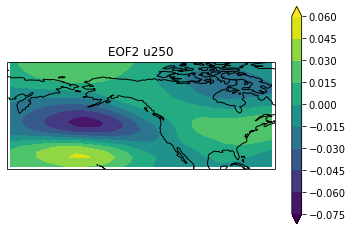

In [20]:
# EOF 2 U250
levs=np.arange(-0.075,0.07,0.015)
u250_eof2=eof1_list[1][1,:,:]/weights_array
ax=plt.axes(projection=proj)
ax.set_extent(extent,crs=ccrs.PlateCarree())
cs=ax.contourf(ds['lon'],ds['lat'],
               u250_eof2,levs,
               transform=ccrs.PlateCarree(),extend='both')
ax.set_title('EOF2 u250')
ax.coastlines()
plt.colorbar(cs)

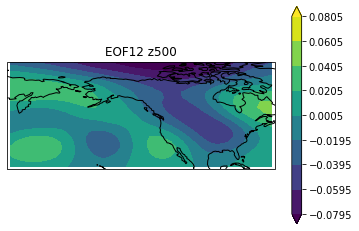

In [21]:
#SAVE Z500 EOFS AS IMAGES

z500_eof1=eof1_array[0][0]
ax=plt.axes(projection=proj)
ax.set_extent(extent,crs=ccrs.PlateCarree())
ax.coastlines()
z_max = np.amax(eof1_array[0])
z_min = np.amin(eof1_array[0])
levs_z=np.arange(z_min,z_max,.02)
cs=ax.contourf(ds['lon'],ds['lat'],
                   z500_eof1*-1,levs_z,
                   transform=ccrs.PlateCarree(),
                  extend='both')
plt.colorbar(cs)

for num in np.arange(0,npcs):
    z500_eof1=eof1_array[0][num]
    cs=ax.contourf(ds['lon'],ds['lat'],
                   z500_eof1*-1,levs_z,
                   transform=ccrs.PlateCarree(),
                  extend='both')
    ax.set_title('EOF' + str(num+1) + ' z500')
    plt.savefig('ERA5_EOF'+str(num+1)+'_z500.png')

/glade/u/home/mkorendy/miniconda3/envs/wxregimes/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


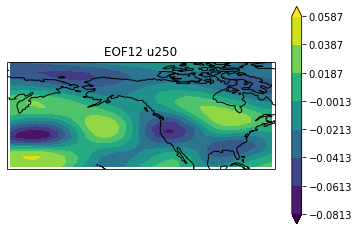

In [22]:
#SAVE U250 EOFS AS IMAGES

u_max = np.amax(eof1_array[1])
u_min = np.amin(eof1_array[1])
levs_u=np.arange(u_min,u_max,.02)

u250_eof2=eof1_array[1][0]
cs=ax.contourf(ds['lon'],ds['lat'],
                   u250_eof2,levs_u,
                   transform=ccrs.PlateCarree(),extend='both')

ax=plt.axes(projection=proj)
ax.set_extent(extent,crs=ccrs.PlateCarree())
ax=plt.axes(projection=proj)
ax.coastlines()
plt.colorbar(cs)

for num in np.arange(0,npcs):
    u250_eof2=eof1_array[1][num]
    cs=ax.contourf(ds['lon'],ds['lat'],
                   u250_eof2,levs,
                   transform=ccrs.PlateCarree(),extend='both')
    ax.set_title('EOF' + str(num+1) + ' u250')
    plt.savefig('ERA5_EOF'+str(num+1)+'_u250.png')

### Get the First 12 PCs

In [23]:
pcs = solver.pcs(npcs=npcs, pcscaling=0)
pcs.shape

(8160, 12)

### Find out how much variance is explained by first 12 PCs; Amini and Straus found about 80%

In [24]:
variance_fractions = solver.varianceFraction(neigs=npcs)
print(variance_fractions * 100)
variance_fractions.sum()*100

[17.7591787  15.38236863  9.10208114  8.76065077  6.27227707  5.863293
  5.27398406  3.03288136  2.66889653  2.42841905  2.34845419  1.99798532]


80.89046984085529

In [26]:
variance_fractions[0:6].sum()*100

63.13984932270843

### Put PCs into `xr.Dataset`

In [25]:
pcs_ds=xr.DataArray(pcs,
                    coords={'time': ds['time'].values,
                            'pcnum':np.arange(npcs)},
                            dims=['time','pcnum'])        
pcs_ds=pcs_ds.to_dataset(name='pcs')

In [26]:
pcs_ds

<xarray.Dataset>
Dimensions:  (pcnum: 12, time: 8160)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 8153 8154 8155 8156 8157 8158 8159
  * pcnum    (pcnum) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    pcs      (time, pcnum) float64 8.55 34.13 23.08 ... -0.1133 0.1309 7.939

### Plot the first PC

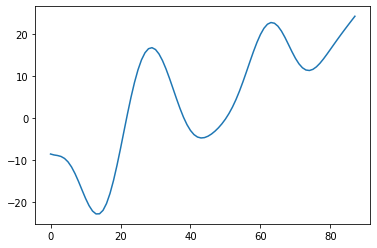

In [27]:
plt.plot(pcs_ds['pcs'][0:88,0]*-1)

In [28]:
pcs_ds.to_netcdf(outfile)
eof1_ds.to_netcdf(eofoutfile)